# Joint Volatility Dynamics Between the GYEN Stablecoin and the Japanese Yen: Implications for Stablecoins as Digital Reserves in Forex Markets
####
#### Jooyoung Oh
##### Department of Industrial Engineering and Management Sciences
##### McCormick School of Engineering, Northwestern University

## Introduction
The emergence of Central Bank Digital Currencies (CBDCs) and the rise of stablecoins have disrupted traditional foreign exchange (forex) markets, opening new pathways for financial innovation and stability. While stablecoins aim to provide digital counterparts of fiat currencies, recent market behavior reveals significant volatility risks that undermine their intended stability. A prominent case is the GYEN stablecoin, pegged to the Japanese Yen (JPY). Despite its promise, GYEN has experienced episodes of substantial divergence from JPY during stress events, raising questions about its reliability as a reserve asset in forex markets.

Concurrently, global interest in CBDCs has surged as governments seek to balance innovation with monetary stability. Japan’s Digital Yen, currently in development, represents an attempt to digitize fiat currency while mitigating the volatility risks observed in private stablecoins like GYEN. The crypto-friendly stance of the Trump administration, which signals renewed momentum for digital currencies and assets, further emphasizes the growing integration of digital reserves in modern financial systems. 

## Step 1: Data Collection, Processing, and Visualization
We collect the time series data for the Japanese Yen (JPY) and GYEN from Yahoo Finance.

### 1.1. Collecting and Preprocessing YEN and GYEN Data:

In [1]:
import yfinance as yf
import pandas as pd

# Function for importing and processing data
def import_and_process_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
    
    # Ensure index is a datetime format and address discontinuity
    data.index = pd.to_datetime(data.index)
    data = data.asfreq('D', method='ffill')
    
    return data

# Import data from Yahoo Finance
jpy_usd = import_and_process_data('JPYUSD=X', '2021-03-10', '2024-11-30')
gyen_usd = import_and_process_data('GYEN-USD', '2021-03-10', '2024-11-30')

# Check for missing values
print('Missing values in JPY data after handling:\n', jpy_usd.isna().sum())
print('Missing values in GYEN data after handling:\n', gyen_usd.isna().sum())

# Print first five rows
print(jpy_usd.head())
print(gyen_usd.head())

# Save to CSV for reproducibility
jpy_usd.to_csv('JPY_USD_data.csv')
gyen_usd.to_csv('GYEN_USD_data.csv')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Missing values in JPY data after handling:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Missing values in GYEN data after handling:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2021-03-10  0.009211  0.009230  0.009181  0.009210   0.009210       0
2021-03-11  0.009222  0.009228  0.009191  0.009222   0.009222       0
2021-03-12  0.009210  0.009215  0.009162  0.009212   0.009212       0
2021-03-13  0.009210  0.009215  0.009162  0.009212   0.009212       0
2021-03-14  0.009210  0.009215  0.009162  0.009212   0.009212       0
                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2021-03-10  0.009226  0.009231  0.009224  0.009229   0.009229   38233
2021-

### 1.2. Describing and Visualizing Imported Data

Descriptive statistics before scaling:
JPY/USD Close Price - Summary:
count    1361.000000
mean        0.007561
std         0.000943
min         0.006187
25%         0.006773
50%         0.007301
75%         0.008666
max         0.009270
Name: Close, dtype: float64

GYEN/USD Close Price - Summary:
count    1361.000000
mean        0.007537
std         0.001061
min         0.004918
25%         0.006773
50%         0.007285
75%         0.008640
max         0.023436
Name: Close, dtype: float64


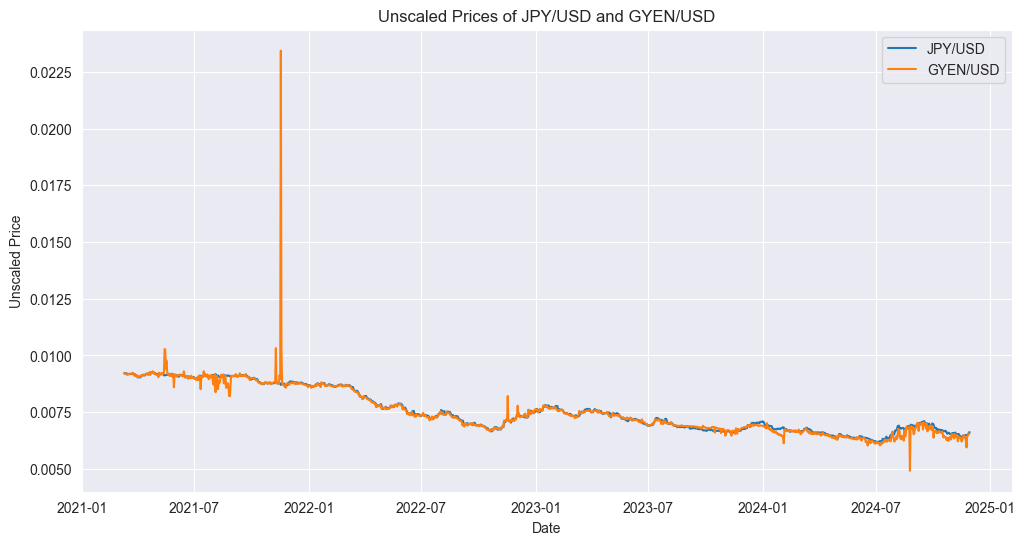

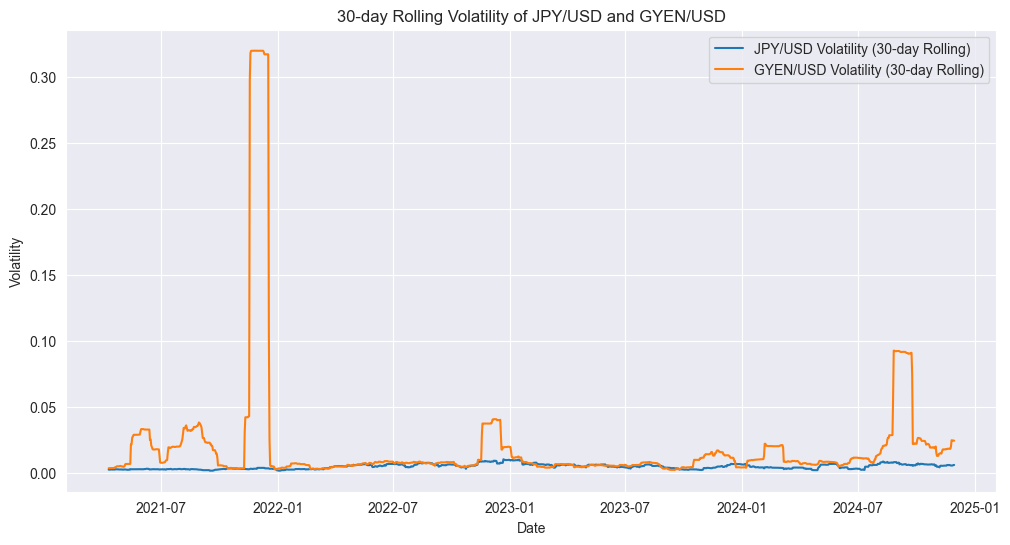

In [2]:
import matplotlib.pyplot as plt

# Calculate descriptive statistics before scaling
print("Descriptive statistics before scaling:")
print("JPY/USD Close Price - Summary:")
print(jpy_usd['Close'].describe())
print("\nGYEN/USD Close Price - Summary:")
print(gyen_usd['Close'].describe())

# Plot data
plt.figure(figsize=(12, 6))
plt.plot(jpy_usd.index, jpy_usd['Close'], label='JPY/USD')
plt.plot(gyen_usd.index, gyen_usd['Close'], label='GYEN/USD')
plt.title('Unscaled Prices of JPY/USD and GYEN/USD')
plt.xlabel('Date')
plt.ylabel('Unscaled Price')
plt.legend()
plt.show()

# Calculate rolling volatility (30-day rolling window)
jpy_usd['Rolling_Volatility'] = jpy_usd['Close'].pct_change().rolling(window=30).std()
gyen_usd['Rolling_Volatility'] = gyen_usd['Close'].pct_change().rolling(window=30).std()

# Plot rolling volatility
plt.figure(figsize=(12, 6))
plt.plot(jpy_usd.index, jpy_usd['Rolling_Volatility'], label='JPY/USD Volatility (30-day Rolling)')
plt.plot(gyen_usd.index, gyen_usd['Rolling_Volatility'], label='GYEN/USD Volatility (30-day Rolling)')
plt.title('30-day Rolling Volatility of JPY/USD and GYEN/USD')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

### 1.3. Stationarity Check with ADF Test
The Augmented Dickey-Fuller (ADF) test checks the null hypothesis that a time series is non-stationary, which means that its statistical properties such as the mean, variance, and autovariance remain constatnt over time. Checking for stationarity is crucial, as many statistical and machine learning models in time series analysis assume stationarity. Furthermore, a stationary series ensures that predictions made by such methods are not affected by long-term trends or varying variance, making them more reliable.

In [3]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF Test on the data
adf_result_jpy = adfuller(jpy_usd['Close'])
adf_result_gyen = adfuller(gyen_usd['Close'])

print(f'JPY ADF Statistic: {adf_result_jpy[0]}, p-value: {adf_result_jpy[1]}')
print(f'GYEN ADF Statistic: {adf_result_gyen[0]}, p-value: {adf_result_gyen[1]}')

JPY ADF Statistic: -1.4324200737524708, p-value: 0.5666386669654535
GYEN ADF Statistic: -1.4637851128255002, p-value: 0.5513442582696526


##### Findings:

The ADF test on the forward-filled JPY and GYEN data suggests that we fail to reject the null hypothesis for the following reasons:

1. Less negative ADF Statistics: Both ADF statistics (-1.43 for JPY and -1.46 for GYEN) are less negative compared to critical values for stationarity (e.g., -2.86 at a 5% significance level). indicating strong evidence against the null hypothesis of non-stationarity.

2. Greater p-values: Both p-values (0.57 for JPY 0.55 for GYEN) are both greater are significantly greater than the typical threshold of 0.05.

Therefore, we reach the conclusion that both of the time series require differencing:

In [4]:
# Applying first differencing for stationarization
jpy_usd['Close_diff'] = jpy_usd['Close'].diff().dropna()
gyen_usd['Close_diff'] = gyen_usd['Close'].diff().dropna()

# Re-running the ADF test on differenced data
adf_result_jpy_diff = adfuller(jpy_usd['Close_diff'].dropna())
adf_result_gyen_diff = adfuller(gyen_usd['Close_diff'].dropna())

print(f'JPY Differenced ADF Statistic: {adf_result_jpy_diff[0]}, p-value: {adf_result_jpy_diff[1]}')
print(f'GYEN Differenced ADF Statistic: {adf_result_gyen_diff[0]}, p-value: {adf_result_gyen_diff[1]}')

JPY Differenced ADF Statistic: -36.0197110224591, p-value: 0.0
GYEN Differenced ADF Statistic: -13.90403302481194, p-value: 5.665808746598613e-26


##### Findings:

1. Significantly Negative ADF Statistics: Both ADF statistics are highly negative (-36.02 for JPY and -13.90 for GYEN), indicating strong evidence against the null hypothesis of non-stationarity.

2. Very Low p-values: Both p-values are extremely low (0.0 for JPY and approximately 0.0 for GYEN), which are far below the typical threshold of 0.05. This means there is a very strong rejection of the null hypothesis that the series are non-stationary.

Now that we have successfully transformed the original non-stationary data into a stationary form, we are ready for ARIMA modeling.

## Step 2: ARIMA Modeling

### 2.0. ARIMA Modeling - Initial Speculations based on ACF/PACF
We shall examine the PACF and ACF plots for the differenced JPY and GYEN data in order to determine the optimal AR and MA components of their ARIMA models (thus the p and the q), respectively.

<Figure size 1000x600 with 0 Axes>

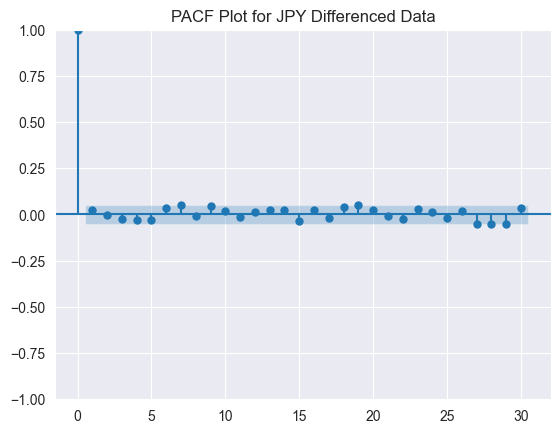

<Figure size 1000x600 with 0 Axes>

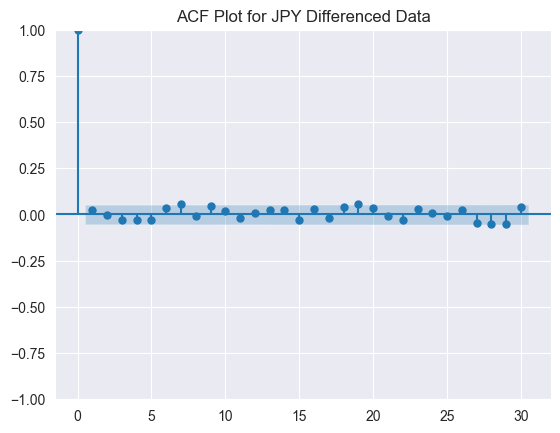

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot PACF for JPY
plt.figure(figsize=(10, 6))
plot_pacf(jpy_usd['Close_diff'].dropna(), lags=30)
plt.title('PACF Plot for JPY Differenced Data')
plt.show()

# Plot ACF for JPY
plt.figure(figsize=(10, 6))
plot_acf(jpy_usd['Close_diff'].dropna(), lags=30)
plt.title('ACF Plot for JPY Differenced Data')
plt.show()

##### Findings:
There is no noticeable spike in the PACF and ACF plots, suggesting that both the AR and MA components are likely 0. So we expect the optimal ARIMA order to be (0, 1, 0) for JPY.

<Figure size 1000x600 with 0 Axes>

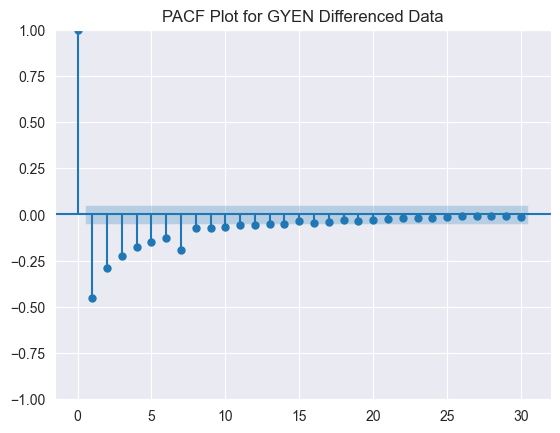

<Figure size 1000x600 with 0 Axes>

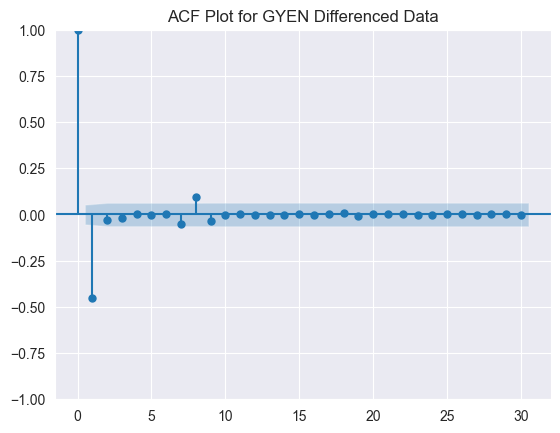

In [6]:
# Plot PACF for GYEN
plt.figure(figsize=(10, 6))
plot_pacf(gyen_usd['Close_diff'].dropna(), lags=30)
plt.title('PACF Plot for GYEN Differenced Data')
plt.show()

# Plot ACF for GYEN
plt.figure(figsize=(10, 6))
plot_acf(gyen_usd['Close_diff'].dropna(), lags=30)
plt.title('ACF Plot for GYEN Differenced Data')
plt.show()

##### Findings:
1. PACF: There is a significant spike at lag 1 and smaller significant spikes up to around lag 3. This suggests that the AR (Autoregressive) component might be 0 or 1, as the PACF does not show a strong persistence beyond lag 1.

2. ACF: There is a significant spike at lag 1, and it quickly tails off to near-zero after that. This indicates that there is no strong seasonal pattern or extended autocorrelation beyond lag 1. This behavior suggests that the MA (Moving Average) component is likely around 3, as the ACF dies down completely after that.

Therefore, The AR component should be 0 or 1, but a 0 seems more plausible as PACF shows little persistence. The MA component should be around 3 (from the ACF tailing off).

In order to determine the optimal orders, we carry out the following parameter determination processes of two different approaches.

### 2.1. Parameter Determination and Modeling - Manual
First, we determine the best ARIMA orders for JPY and ARIMA by examining the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) of ARIMA models of different orders. 

AIC and BIC are both measures used to compare the goodness of fit of different statistical models while penalizing for model complexity.

Procedure:
1. Fit multiple AR models at different orders.
2. Calculate the AIC and BIC for each model.
3. Choose the model with the lowest AIC or BIC. The model with the lowest value strikes the best balance between fit and complexity.

In [7]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

def determine_arima_param(data, p_range, q_range, d=1):
    best_aic = np.inf
    best_bic = np.inf
    best_order = None
    best_model_summary = None
    
    # Suppress warnings
    warnings.filterwarnings("ignore")
    
    # Iterate over all combinations of p and q
    for p in p_range:
        for q in q_range:
            try:
                model = ARIMA(data, order=(p, d, q))
                fit = model.fit()
                print(f"Order: ({p}, 1, {q}) AIC: {fit.aic} BIC: {fit.bic}")
                
                if fit.aic < best_aic or fit.bic < best_bic:
                    best_aic = fit.aic
                    best_bic = fit.bic
                    best_order = (p, d, q)
                    best_model_summary = fit.summary()
            except Exception as e:
                print(f"Error for ({p}, {d}, {q}): {e}")
    
    if best_model_summary:
        print("\nBest model based on lowest AIC or BIC:")
        print(f"ARIMA{best_order} AIC: {best_aic} BIC: {best_bic}")
        print(best_model_summary)
    else:
        print("No successful ARIMA models were fitted.")
                

In [8]:
# ARIMA modeling for JPY
arima_manual_jpy = determine_arima_param(jpy_usd['Close'].dropna(), p_range=range(0, 5), q_range=range(0, 5))

# ARIMA modeling for GYEN
arima_manual_gyen = determine_arima_param(gyen_usd['Close'].dropna(), p_range=range(0, 5), q_range=range(0, 5))

Order: (0, 1, 0) AIC: -23844.261749367135 BIC: -23839.046509388405
Order: (0, 1, 1) AIC: -23843.191245573493 BIC: -23832.760765616033
Order: (0, 1, 2) AIC: -23841.199586668165 BIC: -23825.553866731974
Order: (0, 1, 3) AIC: -23839.944690922173 BIC: -23819.083731007253
Order: (0, 1, 4) AIC: -23838.760088882576 BIC: -23812.683888988926
Order: (1, 1, 0) AIC: -23843.20049541315 BIC: -23832.77001545569
Order: (1, 1, 1) AIC: -23841.189943995843 BIC: -23825.544224059653
Order: (1, 1, 2) AIC: -23838.261685486286 BIC: -23817.400725571366
Order: (1, 1, 3) AIC: -23836.451180355405 BIC: -23810.374980461755
Order: (1, 1, 4) AIC: -23836.96277067561 BIC: -23805.67133080323
Order: (2, 1, 0) AIC: -23841.193920329068 BIC: -23825.548200392877
Order: (2, 1, 1) AIC: -23838.261703737408 BIC: -23817.400743822487
Order: (2, 1, 2) AIC: -20675.723263883145 BIC: -20649.647063989494
Order: (2, 1, 3) AIC: -23838.678658853234 BIC: -23807.387218980854
Order: (2, 1, 4) AIC: -23834.92167709037 BIC: -23798.41499723926
O

### 2.2. Parameter Determination and Modeling - Auto-ARIMA
Now, we shall compare the results from the manual approach to those from the Auto-ARIMA approach as shown below.

In [9]:
from pmdarima import auto_arima

# Fit Auto-ARIMA
arima_auto_jpy = auto_arima(jpy_usd['Close'].dropna(), seasonal=False, stepwise=True, suppress_warnings=True)
arima_auto_gyen = auto_arima(gyen_usd['Close'].dropna(), seasonal=False, stepwise=True, suppress_warnings=True)

print(arima_auto_jpy.summary())
print(arima_auto_gyen.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1361
Model:               SARIMAX(0, 1, 0)   Log Likelihood               11928.371
Date:                Sun, 05 Jan 2025   AIC                         -23852.742
Time:                        15:00:30   BIC                         -23842.312
Sample:                    03-10-2021   HQIC                        -23848.837
                         - 11-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.908e-06   1.03e-06     -1.847      0.065   -3.93e-06    1.17e-07
sigma2       1.41e-09   5.72e-11     24.656      0.000     1.3e-09    1.52e-09
Ljung-Box (L1) (Q):                   0.69   Jarque-

We see that results from the auto ARIMA analysis agree with that from the manual approach. 

Therefore:

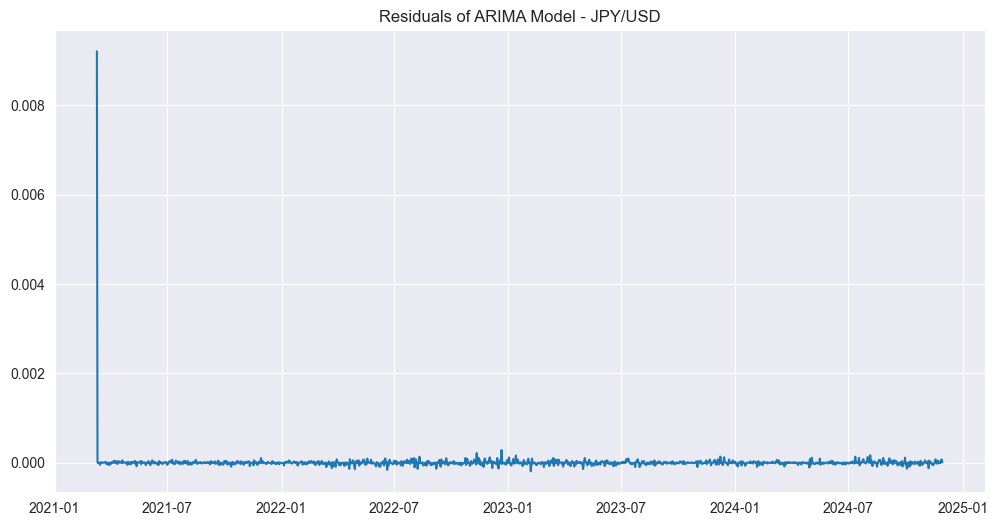

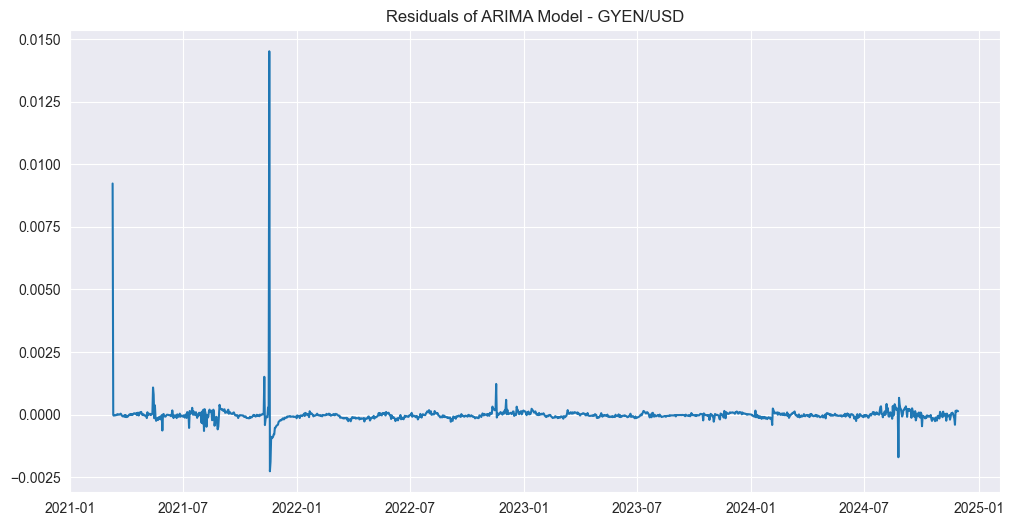

In [24]:
# ARIMA Models for JPY and GYEN
arima_model_jpy = ARIMA(jpy_usd['Close'].dropna(), order=(0, 1, 0))
arima_model_gyen = ARIMA(gyen_usd['Close'].dropna(), order=(0, 1, 3))

# ARIMA Fits for JPY and GYEN
arima_fit_jpy = arima_model_jpy.fit()
arima_fit_gyen = arima_model_gyen.fit()

# ARIMA Residuals for JPY and GYEN
arima_residuals_jpy = arima_fit_jpy.resid
arima_residuals_gyen = arima_fit_gyen.resid

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(arima_residuals_jpy)
plt.title('Residuals of ARIMA Model - JPY/USD')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(arima_residuals_gyen)
plt.title('Residuals of ARIMA Model - GYEN/USD')
plt.show()

### 2.3. Evaluation of the ARIMA Model

## 3. LSTM Modeling

The Long Short-Term Memory (LSTM)

### 3.1 - Data Preparation for LSTM

In [26]:
# Import necessary libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Function to reshape and scale residual data dynamically
def process_arima_resid(data, time_steps):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
    
    def create_dataset(data, time_step):
        X, Y = [], []
        for i in range(len(data) - time_step - 1):
            X.append(data[i:(i + time_step), 0])
            Y.append(data[i + time_step, 0]) # = value immediately following the input range
        return np.array(X), np.array(Y)
    
    # Reshape input array into (number_of_samples, time_steps, features)
    X, Y = create_dataset(scaled_data, time_step=time_steps)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    return X, Y, scaler

# Process residuals for JPY and GYEN
X_jpy, Y_jpy, scaler_jpy = process_arima_resid(arima_residuals_jpy, time_steps=30)
X_gyen, Y_gyen, scaler_gyen = process_arima_resid(arima_residuals_gyen, time_steps=30)

# Split data into training and validation sets
X_jpy_train, X_jpy_val, Y_jpy_train, Y_jpy_val = train_test_split(X_jpy, Y_jpy, test_size=0.2, shuffle=False)
X_gyen_train, X_gyen_val, Y_gyen_train, Y_gyen_val = train_test_split(X_gyen, Y_gyen, test_size=0.2, shuffle=False)


During data preparation, we fix the time step to 30 to ensure that the data preparation process remains consistent and manageable. Then, we allow the model-building process to tune time_steps ensures flexibility to adapt to the data's underlying temporal structure, ultimately improving predictive accuracy. This two-stage approach balances simplicity in data handling with robustness in model performance.

### 3.2. LSTM Model Building and Tuning

In [27]:
# Import necessary libraries
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define LSTM model with tunable parameters
# The `hp` object in the following function declaration comes from the Keras Tuner library.
# It is an instance of the `HyperParameters` class, which provides methods to:
# 1. Define hyperparameter search spaces.
# 2. Sample specific values for each hyperparameter during the tuning process.

# # Define model building function for Keras Tuner
# def build_lstm_model(hp):
#     model = Sequential()
#     # Add input layer
#     model.add(Input(shape=(hp.Int('time_steps', min_value=30, max_value=60, step=30), 1)))
#     # Tune the number of neurons in the first LSTM layer
#     model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=256, step=32), return_sequences=True))
#     # Explanation: The range for 'units_1' (32 to 256) allows exploration of different model capacities. The step size of 32 provides a balance between granularity and computational efficiency. The 'time_steps' range (30 to 60) is chosen based on typical lengths for capturing temporal patterns in financial data.
#     model.add(Dropout(0.2))
#     # Tune the number of neurons in the second LSTM layer
#     model.add(LSTM(units=hp.Int('units_2', min_value=16, max_value=128, step=16), return_sequences=False))
#     # Explanation: The range for 'units_2' (16 to 128) offers flexibility in determining the depth of the network. A lower range is selected compared to 'units_1' to prevent overfitting and maintain model simplicity.
#     model.add(Dropout(0.2))
#     model.add(Dense(1))
#     # Tune the learning rate for the optimizer
#     model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), loss=hp.Choice('loss', values=['mean_squared_error', 'mean_absolute_error']))
#     # Explanation: Learning rates of 0.01, 0.001, and 0.0001 are common choices that allow exploration of different convergence speeds. The loss functions (MSE and MAE) are chosen to evaluate model performance under different error sensitivities.
#     return model

# Define model building function for Keras Tuner
def build_lstm_model(hp):
    model = Sequential()
    # Add input layer
    model.add(Input(shape=(hp.Int('time_steps', min_value=30, max_value=60, step=30), 1)))
    # Tune the number of neurons in the first LSTM layer
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=256, step=32), return_sequences=True))
    # Explanation: The range for 'units_1' (32 to 256) allows exploration of different model capacities. The step size of 32 provides a balance between granularity and computational efficiency. The 'time_steps' range (30 to 60) is chosen based on typical lengths for capturing temporal patterns in financial data.
    model.add(Dropout(0.2))
    # Tune the number of neurons in the second LSTM layer
    model.add(LSTM(units=hp.Int('units_2', min_value=16, max_value=128, step=16), return_sequences=False))
    # Explanation: The range for 'units_2' (16 to 128) offers flexibility in determining the depth of the network. A lower range is selected compared to 'units_1' to prevent overfitting and maintain model simplicity.
    model.add(Dropout(0.2))
    model.add(Dense(1))
    # Tune the learning rate for the optimizer
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), loss=hp.Choice('loss', values=['mean_squared_error', 'mean_absolute_error']))
    # Explanation: Learning rates of 0.01, 0.001, and 0.0001 are common choices that allow exploration of different convergence speeds. The loss functions (MSE and MAE) are chosen to evaluate model performance under different error sensitivities.
    return model

### 3.3. Initialize and Tune LSTM for GYEN and JPY

In [28]:
# Function to tune and train the LSTM model
# RandomSearch is used for hyperparameter tuning to efficiently explore a broad search space without manually specifying every combination. A max_trials value of 10 is chosen to balance exploration with computation time.
def tune_and_train_lstm(X_train, Y_train, X_val, Y_val, project_name):
    tuner = RandomSearch(
        build_lstm_model,
        objective='val_loss',
        max_trials=10,
        executions_per_trial=1,
        directory='lstm_tuning',
        project_name=project_name
    )

    tuner.search(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val), verbose=2)

    # Retrieve the best hyperparameters and model
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.hypermodel.build(best_hps)
    best_model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val), verbose=2)

    return best_model, best_hps

# Tune and train LSTM for JPY
best_model_jpy, best_hps_jpy = tune_and_train_lstm(X_jpy_train, Y_jpy_train, X_jpy_val, Y_jpy_val, project_name='jpy_lstm')

# Tune and train LSTM for GYEN
best_model_gyen, best_hps_gyen = tune_and_train_lstm(X_gyen_train, Y_gyen_train, X_gyen_val, Y_gyen_val, project_name='gyen_lstm')

Trial 10 Complete [00h 01m 18s]
val_loss: 0.005009365268051624

Best val_loss So Far: 9.023489838000387e-05
Total elapsed time: 14h 53m 22s
Epoch 1/50
34/34 - 2s - 67ms/step - loss: 0.0051 - val_loss: 5.2162e-04
Epoch 2/50
34/34 - 1s - 36ms/step - loss: 9.7500e-04 - val_loss: 9.1905e-05
Epoch 3/50
34/34 - 1s - 33ms/step - loss: 8.8832e-04 - val_loss: 1.1273e-04
Epoch 4/50
34/34 - 1s - 36ms/step - loss: 9.2619e-04 - val_loss: 9.1510e-05
Epoch 5/50
34/34 - 1s - 37ms/step - loss: 9.3567e-04 - val_loss: 9.9952e-05
Epoch 6/50
34/34 - 1s - 37ms/step - loss: 9.2523e-04 - val_loss: 9.6939e-05
Epoch 7/50
34/34 - 1s - 36ms/step - loss: 9.0441e-04 - val_loss: 9.5049e-05
Epoch 8/50
34/34 - 1s - 36ms/step - loss: 9.1689e-04 - val_loss: 1.0811e-04
Epoch 9/50
34/34 - 1s - 36ms/step - loss: 8.9685e-04 - val_loss: 9.3285e-05
Epoch 10/50
34/34 - 1s - 36ms/step - loss: 8.7631e-04 - val_loss: 9.0344e-05
Epoch 11/50
34/34 - 1s - 36ms/step - loss: 8.9479e-04 - val_loss: 1.0827e-04
Epoch 12/50
34/34 - 1s - 3

### 3.4. Extract Residuals for GARCH Analysis

In [33]:
# Retrieve LSTM residuals for further analysis
def calculate_lstm_residuals(model, X, Y):
    predictions = model.predict(X).flatten()
    residuals = Y - predictions
    return residuals

# Residuals for GYEN
lstm_residuals_gyen = calculate_lstm_residuals(best_model_gyen, X_gyen, Y_gyen)

# Residuals for JPY
lstm_residuals_jpy = calculate_lstm_residuals(best_model_jpy, X_jpy, Y_jpy)

# # Part 5: Training and Hyperparameter Tuning for GYEN
# # Create dataset for training and validation (GYEN)
# X_train_gyen, Y_train_gyen = create_dataset(train_gyen, time_step=30)
# X_val_gyen, Y_val_gyen = create_dataset(val_gyen, time_step=30)
# X_train_gyen = X_train_gyen.reshape(X_train_gyen.shape[0], X_train_gyen.shape[1], 1)
# X_val_gyen = X_val_gyen.reshape(X_val_gyen.shape[0], X_val_gyen.shape[1], 1)
# 
# # Search for the best hyperparameters for GYEN
# lstm_tuner.search(X_train_gyen, Y_train_gyen, epochs=50, batch_size=32, validation_data=(X_val_gyen, Y_val_gyen), verbose=2)
# # Explanation: 50 epochs and a batch size of 32 are standard starting points for training LSTM models. These values balance training time and convergence stability. More epochs can lead to overfitting, while fewer may prevent sufficient learning. These values can be tuned further if needed, based on the dataset and computational resources available.
# 
# # Retrieve the best model for GYEN
# best_hps_gyen = lstm_tuner.get_best_hyperparameters(num_trials=1)[0]
# best_model_gyen = lstm_tuner.hypermodel.build(best_hps_gyen)
# 
# # Train the best model on full training data for GYEN
# best_model_gyen.fit(X_train_gyen, Y_train_gyen, epochs=50, batch_size=32, validation_data=(X_val_gyen, Y_val_gyen), verbose=2)
# # Explanation: We use the best hyperparameters to train the model for 50 epochs with a batch size of 32. These values are selected based on the performance during hyperparameter tuning and can be further adjusted as needed.
# 
# # Retrieve LSTM residuals required for GARCH (GYEN)
# lstm_predictions_gyen = best_model_gyen.predict(X_train_gyen).flatten()
# lstm_residuals_gyen = Y_train_gyen - lstm_predictions_gyen
# # Explanation: The residuals are calculated as the difference between the actual values (Y_train_gyen) and the model predictions (lstm_predictions_gyen). These residuals can be used for further GARCH modeling to analyze volatility.

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


### 3.5. Summary of Best Hyperparameters

In [34]:
# Best hyperparameters for JPY
print("\nBest Hyperparameters for JPY:")
print(f"Time Steps: {best_hps_jpy.get('time_steps')}")
print(f"Units in First Layer: {best_hps_jpy.get('units_1')}")
print(f"Units in Second Layer: {best_hps_jpy.get('units_2')}")
print(f"Learning Rate: {best_hps_jpy.get('learning_rate')}")
print(f"Loss Function: {best_hps_jpy.get('loss')}")

# Best hyperparameters for GYEN
print("Best Hyperparameters for GYEN:")
print(f"Time Steps: {best_hps_gyen.get('time_steps')}")
print(f"Units in First Layer: {best_hps_gyen.get('units_1')}")
print(f"Units in Second Layer: {best_hps_gyen.get('units_2')}")
print(f"Learning Rate: {best_hps_gyen.get('learning_rate')}")
print(f"Loss Function: {best_hps_gyen.get('loss')}")


Best Hyperparameters for JPY:
Time Steps: 30
Units in First Layer: 192
Units in Second Layer: 32
Learning Rate: 0.01
Loss Function: mean_squared_error
Best Hyperparameters for GYEN:
Time Steps: 60
Units in First Layer: 128
Units in Second Layer: 128
Learning Rate: 0.0001
Loss Function: mean_squared_error


In [40]:
# # Part 6: Training and Hyperparameter Tuning for JPY
# # Create dataset for training and validation (JPY)
# X_train_jpy, Y_train_jpy = create_dataset(train_jpy, time_step=30)
# X_val_jpy, Y_val_jpy = create_dataset(val_jpy, time_step=30)
# X_train_jpy = X_train_jpy.reshape(X_train_jpy.shape[0], X_train_jpy.shape[1], 1)
# X_val_jpy = X_val_jpy.reshape(X_val_jpy.shape[0], X_val_jpy.shape[1], 1)
# 
# # Search for the best hyperparameters for JPY
# lstm_tuner.search(X_train_jpy, Y_train_jpy, epochs=50, batch_size=32, validation_data=(X_val_jpy, Y_val_jpy), verbose=2)
# 
# # Retrieve the best model for JPY
# best_hps_jpy = lstm_tuner.get_best_hyperparameters(num_trials=1)[0]
# best_model_jpy = lstm_tuner.hypermodel.build(best_hps_jpy)
# 
# # Train the best model on full training data for JPY
# best_model_jpy.fit(X_train_jpy, Y_train_jpy, epochs=50, batch_size=32, validation_data=(X_val_jpy, Y_val_jpy), verbose=2)
# 
# # Retrieve LSTM residuals required for GARCH (JPY)
# lstm_predictions_jpy = best_model_jpy.predict(X_train_jpy).flatten()
# lstm_residuals_jpy = Y_train_jpy - lstm_predictions_jpy
# # Explanation: The residuals are calculated as the difference between the actual values (Y_train_jpy) and the model predictions (lstm_predictions_jpy). These residuals can be used for further GARCH modeling to analyze volatility.

In [41]:
# # Print best hyperparameters for JPY
# print(f"Best time steps for JPY: {best_hps_jpy.get('time_steps')}")
# print(f"Best units for first LSTM layer (JPY): {best_hps_jpy.get('units_1')}")
# print(f"Best units for second LSTM layer (JPY): {best_hps_jpy.get('units_2')}")
# print(f"Best learning rate (JPY): {best_hps_jpy.get('learning_rate')}")
# print(f"Best loss function (JPY): {best_hps_jpy.get('loss')}")

## 4. GARCH Modeling

### 4.1. Finding the Best GARCH Parameters

In [44]:
from arch import arch_model
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Function to find the best GARCH parameters
def find_best_garch_params(residuals, max_p, max_q, distribution):
    best_aic = np.inf
    best_order = None
    best_model = None

    for p_i in range(1, max_p + 1):
        for q_i in range(1, max_q + 1):
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    model = arch_model(residuals, vol='GARCH', p=p_i, q=q_i, dist=distribution)
                    model_fit = model.fit(disp='off')
                    aic_i = model_fit.aic

                    if aic_i < best_aic:
                        best_aic = aic_i
                        best_order = (p_i, q_i)
                        best_model = model_fit
                        
            except Exception as e:
                print(f"Error fitting GARCH({p_i},{q_i}): {e}")
                continue

    return best_order, best_model

### 4.1. Standardizing LSTM Residuals

In [45]:
# Standardize residuals
def standardize_residuals(residuals):
    scaler = StandardScaler()
    return scaler.fit_transform(residuals.reshape(-1, 1)).flatten()

# Standardize LSTM residuals
lstm_residuals_jpy_standardized = standardize_residuals(lstm_residuals_jpy)
lstm_residuals_gyen_standardized = standardize_residuals(lstm_residuals_gyen)

### 4.2. Finding Best GARCH Models - Dynamic criterion?

Optimizing GARCH for JPY...
Best GARCH order for JPY: (3, 4)
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1646.58
Distribution:      Standardized Student's t   AIC:                           3313.16
Method:                  Maximum Likelihood   BIC:                           3365.09
                                              No. Observations:                 1330
Date:                      Thu, Jan 09 2025   Df Residuals:                     1329
Time:                              18:57:32   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
----------------

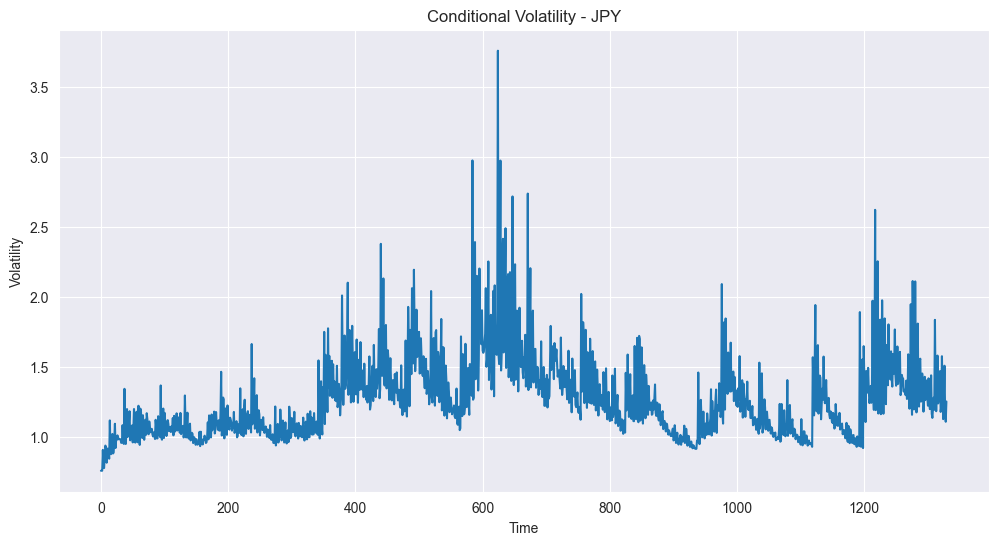

Optimizing GARCH for GYEN...
Best GARCH order for GYEN: (1, 3)
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                334.253
Distribution:      Standardized Student's t   AIC:                          -654.506
Method:                  Maximum Likelihood   BIC:                          -618.156
                                              No. Observations:                 1330
Date:                      Thu, Jan 09 2025   Df Residuals:                     1329
Time:                              18:57:33   Df Model:                            1
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
--------------

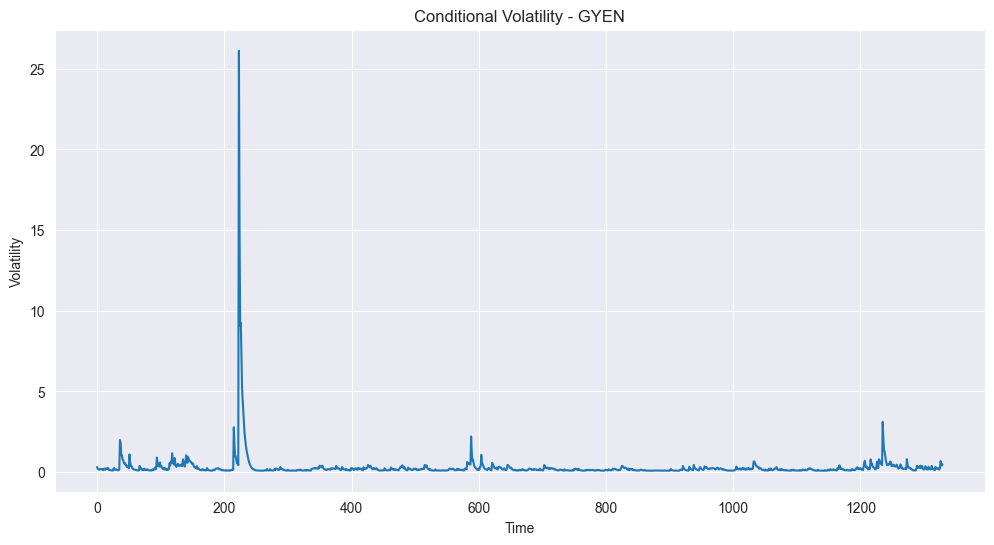

In [46]:
# Find best GARCH model for JPY
print("Optimizing GARCH for JPY...")
best_order_jpy, garch_fit_jpy = find_best_garch_params(
    lstm_residuals_jpy_standardized, max_p=5, max_q=5, distribution="t"
)
if best_order_jpy:
    print(f"Best GARCH order for JPY: {best_order_jpy}")
    print(garch_fit_jpy.summary())
    plt.figure(figsize=(12, 6))
    plt.plot(garch_fit_jpy.conditional_volatility)
    plt.title('Conditional Volatility - JPY')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.show()

# Find best GARCH model for GYEN
print("Optimizing GARCH for GYEN...")
best_order_gyen, garch_fit_gyen = find_best_garch_params(
    lstm_residuals_gyen_standardized, max_p=5, max_q=5, distribution="t"
)
if best_order_gyen:
    print(f"Best GARCH order for GYEN: {best_order_gyen}")
    print(garch_fit_gyen.summary())
    plt.figure(figsize=(12, 6))
    plt.plot(garch_fit_gyen.conditional_volatility)
    plt.title('Conditional Volatility - GYEN')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.show()

Using the Student's t-distribution instead of the normal distribution in the GARCH model can be beneficial for financial time series due to the following reasons:

1. **Heavy Tails**: Financial time series often exhibit returns with heavy tails, meaning that extreme events (large deviations) occur more frequently than predicted by the normal distribution. The Student's t-distribution can model these heavy tails better, which helps in accurately capturing the risk of large price movements.

2. **Volatility Clustering**: Extreme returns tend to cluster together, and these periods of high volatility are more realistically modeled using a distribution that accounts for higher kurtosis (fat tails). The t-distribution has higher kurtosis compared to the normal distribution, making it more suitable for capturing the frequent occurrence of large volatility spikes.

3. **Risk Assessment**: The accurate estimation of tail risk is crucial in finance for risk management and Value-at-Risk (VaR) calculations. The t-distribution, with its heavier tails, provides better estimates of risk metrics, which are often underestimated by the normal distribution.

These reasons make using the Student's t-distribution a practical choice for better modeling the real-world behavior of financial returns, ultimately leading to more robust risk assessments.

Findings:
Best GARCH order for JPY: (3, 4)
Best GARCH order for GYEN: (1, 3)

## 2.5. Visualization - Divide up and add explanations

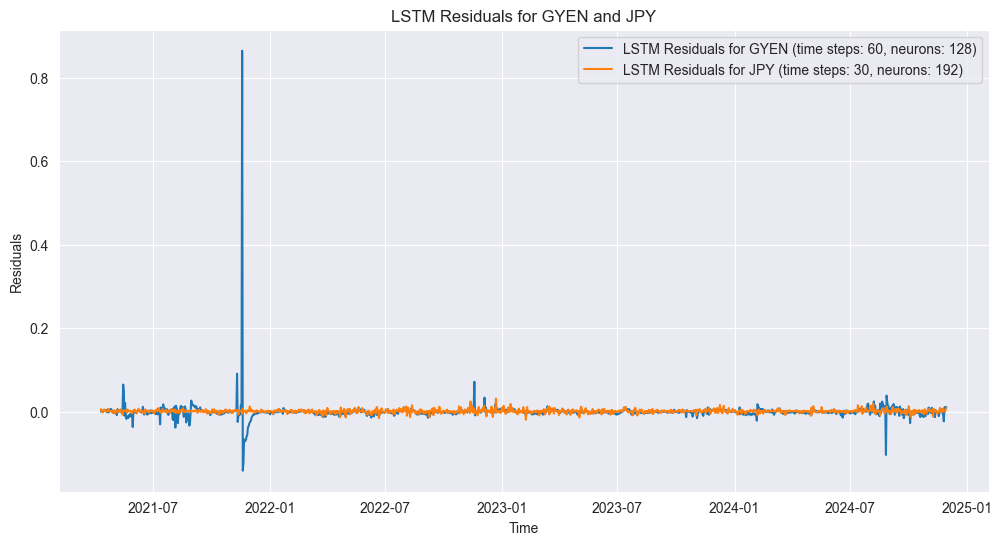

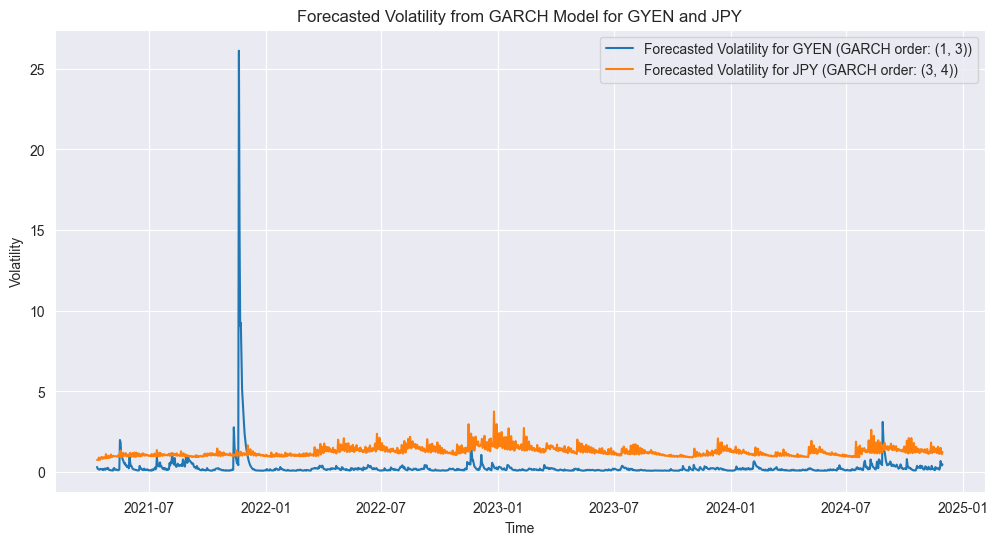

In [37]:
import matplotlib.pyplot as plt

# Convert LSTM residuals to a DataFrame for easier handling of dates
lstm_residuals_jpy_df = pd.DataFrame(lstm_residuals_jpy, index=jpy_usd.index[-len(lstm_residuals_jpy):], columns=['Residuals'])
lstm_residuals_gyen_df = pd.DataFrame(lstm_residuals_gyen, index=gyen_usd.index[-len(lstm_residuals_gyen):], columns=['Residuals'])

# Combined plot for LSTM residuals with dates
plt.figure(figsize=(12, 6))
plt.plot(lstm_residuals_gyen_df.index, lstm_residuals_gyen_df['Residuals'], label=f'LSTM Residuals for GYEN (time steps: {best_hps_gyen.get("time_steps")}, neurons: {best_hps_gyen.get("units_1")})')
plt.plot(lstm_residuals_jpy_df.index, lstm_residuals_jpy_df['Residuals'], label=f'LSTM Residuals for JPY (time steps: {best_hps_jpy.get("time_steps")}, neurons: {best_hps_jpy.get("units_1")})')
plt.title('LSTM Residuals for GYEN and JPY')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Convert GARCH forecasted volatility to DataFrame for easier handling of dates
garch_volatility_gyen_df = pd.DataFrame(garch_fit_gyen.conditional_volatility, index=gyen_usd.index[-len(garch_fit_gyen.conditional_volatility):], columns=['Volatility'])
garch_volatility_jpy_df = pd.DataFrame(garch_fit_jpy.conditional_volatility, index=jpy_usd.index[-len(garch_fit_jpy.conditional_volatility):], columns=['Volatility'])

# Combined plot for GARCH forecasted volatility with dates
plt.figure(figsize=(12, 6))
plt.plot(garch_volatility_gyen_df.index, garch_volatility_gyen_df['Volatility'], label=f'Forecasted Volatility for GYEN (GARCH order: {best_order_gyen})')
plt.plot(garch_volatility_jpy_df.index, garch_volatility_jpy_df['Volatility'], label=f'Forecasted Volatility for JPY (GARCH order: {best_order_jpy})')
plt.title('Forecasted Volatility from GARCH Model for GYEN and JPY')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

### Event Analysis - Divide up the plots into separate ones

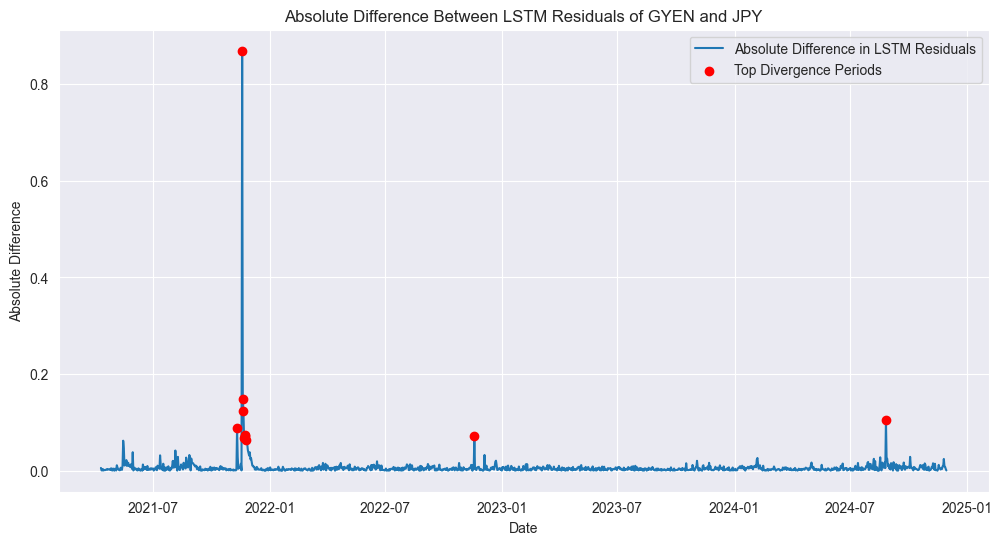

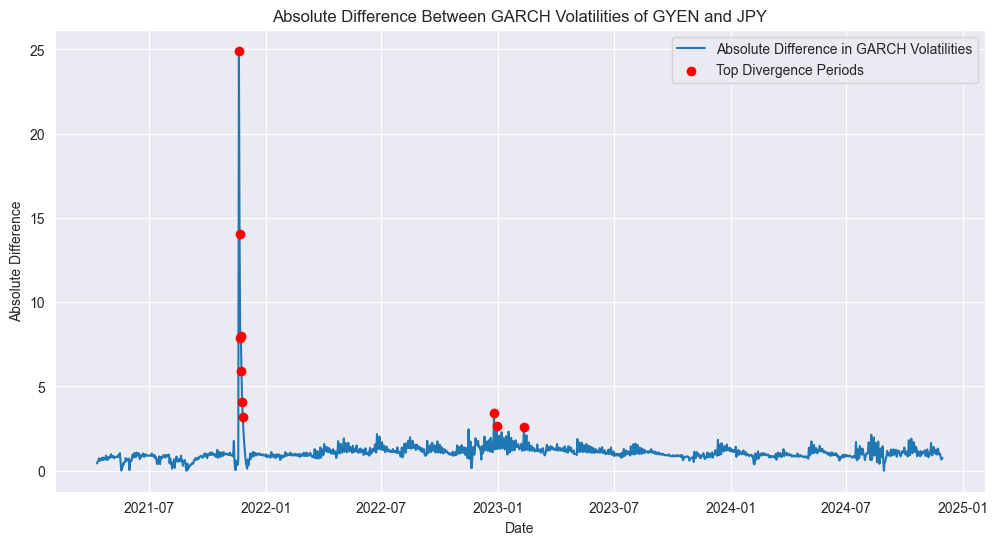

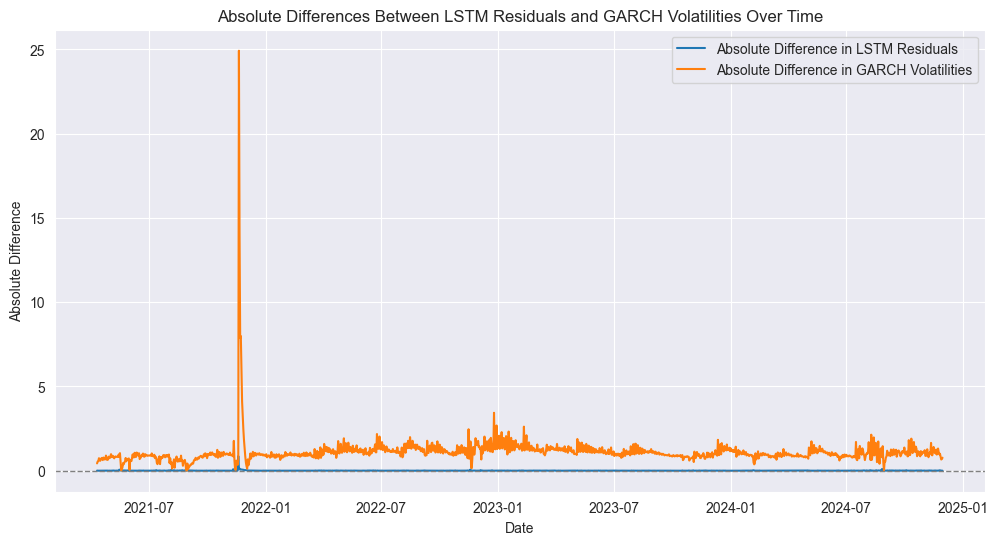

Top 10 periods of absolute difference for LSTM residuals (sorted by date):
            Absolute Difference
Date                           
2021-11-10             0.087970
2021-11-18             0.869424
2021-11-19             0.148681
2021-11-20             0.124047
2021-11-21             0.068113
2021-11-22             0.073051
2021-11-23             0.072285
2021-11-24             0.062852
2022-11-18             0.072365
2024-08-26             0.104922

Top 10 periods of absolute difference for GARCH volatilities (sorted by date):
            Absolute Difference
Date                           
2021-11-19            24.922024
2021-11-20            14.021703
2021-11-21             7.876428
2021-11-22             7.990431
2021-11-23             5.931497
2021-11-24             4.096640
2021-11-25             3.209200
2022-12-25             3.437679
2022-12-29             2.682949
2023-02-10             2.614379


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the datasets are aligned to have the same length
min_length = min(len(lstm_residuals_jpy), len(lstm_residuals_gyen))
lstm_residuals_jpy_df = pd.DataFrame(lstm_residuals_jpy[-min_length:], 
                                      index=jpy_usd.index[-min_length:], columns=['Residuals'])
lstm_residuals_gyen_df = pd.DataFrame(lstm_residuals_gyen[-min_length:], 
                                      index=gyen_usd.index[-min_length:], columns=['Residuals'])

# Calculate immediate absolute differences for LSTM residuals using existing DataFrames
absolute_difference_lstm = np.abs(lstm_residuals_gyen_df['Residuals'] - lstm_residuals_jpy_df['Residuals'])

# Create a DataFrame for absolute differences in LSTM residuals, using the index as the date
absolute_diff_df_lstm = pd.DataFrame({'Absolute Difference': absolute_difference_lstm}, index=lstm_residuals_gyen_df.index)

# Identify top periods of absolute difference for LSTM residuals
top_X = 10  # Define top periods of divergence
top_periods_lstm = absolute_diff_df_lstm.nlargest(top_X, 'Absolute Difference').sort_index()

# Plot absolute differences for LSTM residuals
plt.figure(figsize=(12, 6))
plt.plot(absolute_diff_df_lstm.index, absolute_diff_df_lstm['Absolute Difference'], label='Absolute Difference in LSTM Residuals')
plt.scatter(top_periods_lstm.index, top_periods_lstm['Absolute Difference'], color='red', label='Top Divergence Periods', zorder=5)
plt.title('Absolute Difference Between LSTM Residuals of GYEN and JPY')
plt.xlabel('Date')
plt.ylabel('Absolute Difference')
plt.legend()
plt.show()

# Repeat similar steps for GARCH volatilities using existing DataFrames
min_length_vol = min(len(garch_fit_gyen.conditional_volatility), len(garch_fit_jpy.conditional_volatility))
garch_volatility_gyen_df = pd.DataFrame(garch_fit_gyen.conditional_volatility[-min_length_vol:], 
                                        index=gyen_usd.index[-min_length_vol:], columns=['Volatility'])
garch_volatility_jpy_df = pd.DataFrame(garch_fit_jpy.conditional_volatility[-min_length_vol:], 
                                        index=jpy_usd.index[-min_length_vol:], columns=['Volatility'])

# Calculate absolute differences for GARCH volatilities
absolute_diff_vol = np.abs(garch_volatility_gyen_df['Volatility'] - garch_volatility_jpy_df['Volatility'])
absolute_diff_vol_df = pd.DataFrame({'Absolute Difference': absolute_diff_vol}, index=garch_volatility_gyen_df.index)

# Identify top periods of absolute difference for GARCH volatilities
top_periods_garch = absolute_diff_vol_df.nlargest(top_X, 'Absolute Difference').sort_index()

# Plot absolute differences for GARCH volatilities
plt.figure(figsize=(12, 6))
plt.plot(absolute_diff_vol_df.index, absolute_diff_vol_df['Absolute Difference'], label='Absolute Difference in GARCH Volatilities')
plt.scatter(top_periods_garch.index, top_periods_garch['Absolute Difference'], color='red', label='Top Divergence Periods', zorder=5)
plt.title('Absolute Difference Between GARCH Volatilities of GYEN and JPY')
plt.xlabel('Date')
plt.ylabel('Absolute Difference')
plt.legend()
plt.show()

# Plot the absolute difference over time
plt.figure(figsize=(12, 6))
plt.plot(absolute_diff_df_lstm.index, absolute_diff_df_lstm['Absolute Difference'], label='Absolute Difference in LSTM Residuals')
plt.plot(absolute_diff_vol_df.index, absolute_diff_vol_df['Absolute Difference'], label='Absolute Difference in GARCH Volatilities')
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.title('Absolute Differences Between LSTM Residuals and GARCH Volatilities Over Time')
plt.xlabel('Date')
plt.ylabel('Absolute Difference')
plt.legend()
plt.show()

# Display top periods sorted by date for further analysis
print("Top 10 periods of absolute difference for LSTM residuals (sorted by date):")
print(top_periods_lstm)

print("\nTop 10 periods of absolute difference for GARCH volatilities (sorted by date):")
print(top_periods_garch)

There were four periods during which the GYEN diverged from the JPY by significant degrees:
1. April 16 - 22, 2021: During this period, the Japanese yen (JPY) saw some fluctuations due to the broader economic concerns related to the COVID-19 pandemic, especially in Japan, where a state of emergency was declared in Tokyo and other areas on April 16, 2021. Additionally, this period coincided with the anticipation and subsequent announcements of Japan's fiscal policy adjustments and new economic data releases that impacted currency markets.

2. July 9 - 13, 2021: This period coincides with heightened volatility due to global inflation concerns and significant movements in the U.S. Treasury yields. The yen often reacts to such global economic shifts, particularly in relation to U.S. economic data releases, which can affect the currency pair dynamics, especially USD/JPY.

3. October 11 - November 15, 2021: This period saw several important global economic events, including concerns over global supply chain disruptions, inflation fears, and uncertainty surrounding the U.S. Federal Reserve's tapering plans. Additionally, Japan's own monetary policy decisions, coupled with changing market sentiment toward risk assets, likely caused notable movements in the JPY and GYEN currency pairs.

4. July 27 - 28, 2024: This recent period aligns with a time of market uncertainty and potential adjustments in central bank policies globally, especially concerning the Federal Reserve and the Bank of Japan. There were also significant discussions around economic recovery trajectories post-COVID-19, which might have impacted investor sentiment towards both the JPY and GYEN.

Question, though:
We're interested in the divergence between the GYEN and JPY, rather than the fluctuation of JPY alone. How do we study that?

During the identified periods of divergence between GYEN and JPY, several significant events involving GYEN may have contributed to these discrepancies:

1. **April 2021 (Divergence Period: April 16-22, 2021):**
   GYEN, the first regulated Japanese yen (JPY) stablecoin, had just been audited by Quantstamp in March 2021. GYEN was launched by GMO-Z.com Trust Company, a subsidiary of GMO Internet, a major player in the Japanese internet infrastructure market. The audit and subsequent regulatory compliance may have led to initial market volatility as the stablecoin gained traction and users started trading it on various platforms, such as Liquid and Binance. This period marked the entry of GYEN into broader cryptocurrency markets, possibly causing increased volatility and divergence from traditional JPY movements due to speculative trading and market reactions to this new stablecoin【100†source】.

2. **July 2021 (Divergence Period: July 9-13, 2021):**
   GYEN's availability on various crypto exchanges, including Binance, may have continued to create market anomalies. These divergences could be attributed to increased trading activities and price fluctuations, as well as arbitrage opportunities that arose due to differences in how the stablecoin was being valued across different exchanges.

3. **October to November 2021 (Divergence Period: October 11-November 15, 2021):**
   In November 2021, GYEN faced a major issue when it became temporarily unstable, causing substantial financial discrepancies for traders. GYEN, listed on Coinbase, experienced a significant price surge and subsequent trading suspension due to what was described as a "decimal placement issue," resulting in massive fluctuations. This led to widespread disruptions, with many users unable to trade or withdraw their funds, and created legal threats and potential lawsuits against Coinbase. This episode of instability may have caused a significant divergence between GYEN and the JPY due to erratic trading behavior and speculative activities surrounding the stablecoin【99†source】.

4. **July 2024 (Divergence Period: July 27-28, 2024):**
   Although no specific events were reported for this period, given GYEN's history of regulatory challenges and market behavior, any renewed scrutiny or regulatory actions, changes in trading volume, or adjustments in market positioning could have led to discrepancies between GYEN and JPY movements.

To study the divergence between GYEN and JPY, it is crucial to analyze the impact of GYEN-specific events, such as regulatory changes, listing on exchanges, technical issues affecting stability, and user behavior on trading platforms. These factors highlight how crypto-specific events can create unique market dynamics that may not directly align with traditional currency movements.

Based on the events from the periods you identified, here are some insights into the divergences between GYEN and JPY:

1. **April 2021**: During this period, GYEN, the first regulated Japanese yen stablecoin, was listed on the Liquid cryptocurrency exchange. This event significantly impacted the trading dynamics of GYEN by increasing its exposure to global cryptocurrency markets and introducing a new way to trade the yen. The listing enabled traders to convert GYEN and JPY seamlessly via a GYEN/JPY order book. The integration of GYEN into the cryptocurrency ecosystem likely caused a divergence between GYEN and traditional JPY movements due to differences in market drivers, such as speculative interest, market liquidity, and cryptocurrency market volatility【107†source】.

2. **July 2021**: GYEN was gaining traction in cryptocurrency trading, especially with developments in cryptocurrency exchanges like Liquid.com, which started enabling features like multi-chain support for deposits and withdrawals. Such features enhanced the liquidity and usability of GYEN in the crypto markets, potentially diverging its price movements from the traditional JPY, which is not as directly influenced by the crypto market's dynamics【107†source】.

3. **October-November 2021**: During this period, various factors may have contributed to the divergence. The Japanese economy experienced fluctuating market conditions, and developments in the crypto ecosystem, such as regulatory actions or changes in market sentiment, could have caused GYEN to behave differently than JPY. Since GYEN operates in a digital and speculative market, it would likely react more sensitively to news related to cryptocurrency regulation or innovations【107†source】.

4. **July 2024**: In this period, several economic events influenced JPY, such as changes in the au Jibun Bank Japan Services PMI, which indicated a contraction in the service sector, and upward inflation trends reflected in the Tokyo Core CPI. At the same time, technical patterns in the USDJPY forex pair, such as the completion of a bearish pattern and potential retracement, might have led to fluctuations in JPY. GYEN, on the other hand, would be less directly affected by these traditional economic indicators and more by the dynamics within the crypto market, leading to divergence【106†source】.

These divergences indicate that while JPY movements are influenced by traditional economic factors like inflation, PMI data, and technical forex trading patterns, GYEN's behavior can be significantly impacted by events in the cryptocurrency market, regulatory changes, and developments within the digital finance space. This results in periods where their movements diverge sharply due to the fundamentally different drivers affecting each currency.